In [46]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from geopy.distance import geodesic as gd

### Устанавливаем модуль для пересчета координат в расстояния

In [48]:
# pip install geopy

### Читаем датасет и проводим первое знакомство

In [3]:
df = pd.read_csv('query_result_2021-11-21T20_07_29.560345Z.csv')

In [60]:
df.sample(5)

,flight_id,flight_no,dep_city,dep_tz,dep_lon,dep_lat,arr_city,arr_tz,arr_lon,arr_lat,...,actual_departure_month,actual_arrival_month,dist,sum_per_km,fuel,inc_per_person,profit_per_flight,min_rev,res,prfbty
75,136630,PG0480,Anapa,Europe/Moscow,37.347301,45.002102,Belgorod,Europe/Moscow,36.590099,50.643799,...,2,2,629,1186.645469,108333.333333,7940.425532,6.889846,425000.0,321400.0,26.499408
95,136758,PG0480,Anapa,Europe/Moscow,37.347301,45.002102,Belgorod,Europe/Moscow,36.590099,50.643799,...,1,1,629,1216.693164,108333.333333,7889.690722,7.064308,425000.0,340300.0,27.170414
11,136172,PG0252,Anapa,Europe/Moscow,37.347301,45.002102,Moscow,Europe/Moscow,37.414600,55.972599,...,1,1,1220,1325.901639,216666.666667,14705.454545,7.465846,850000.0,767600.0,28.714793
92,136754,PG0480,Anapa,Europe/Moscow,37.347301,45.002102,Belgorod,Europe/Moscow,36.590099,50.643799,...,2,2,629,1146.581876,108333.333333,8013.333333,6.657231,425000.0,296200.0,25.604734
113,136869,PG0480,Anapa,Europe/Moscow,37.347301,45.002102,Belgorod,Europe/Moscow,36.590099,50.643799,...,1,1,629,1216.693164,108333.333333,7889.690722,7.064308,425000.0,340300.0,27.170414


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 126
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   flight_id                  118 non-null    int64              
 1   flight_no                  118 non-null    object             
 2   dep_city                   118 non-null    object             
 3   dep_tz                     118 non-null    object             
 4   dep_lon                    118 non-null    float64            
 5   dep_lat                    118 non-null    float64            
 6   arr_city                   118 non-null    object             
 7   arr_tz                     118 non-null    object             
 8   arr_lon                    118 non-null    float64            
 9   arr_lat                    118 non-null    float64            
 10  model                      118 non-null    object             
 11  range 

### Переводим формат столбцов с датами в datetime

In [50]:
df.scheduled_departure = pd.to_datetime(df.scheduled_departure)
df.scheduled_arrival = pd.to_datetime(df.scheduled_arrival)
df.actual_departure = pd.to_datetime(df.actual_departure)
df.actual_arrival = pd.to_datetime(df.actual_arrival)

### Выделяем месяц из дат

In [7]:
df['scheduled_departure_month'] = df['scheduled_departure'].dt.month
df['scheduled_arrival_month'] = df['scheduled_arrival'].dt.month
df['actual_departure_month'] = df['actual_departure'].dt.month
df['actual_arrival_month'] = df['actual_arrival'].dt.month

### Рассчитываем расстояния между Анапой и портами прилета

In [8]:
dep_lat = df.dep_lat[0]
dep_lon = df.dep_lon[0]
df.loc[:, 'dist'] = 0
for row in range(df.shape[0]):
    arr_lat = df.arr_lat[row]
    arr_lon = df.arr_lon[row]
    df.dist[row] = gd((dep_lat,dep_lon),(arr_lat,arr_lon)).km

<ipython-input-8-52ce5fee7c79>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dist[row] = gd((dep_lat,dep_lon),(arr_lat,arr_lon)).km


In [51]:
df['dist']

0      1220
1      1220
2      1220
3      1220
4      1220
       ... 
122     629
123     629
124     629
125     629
126     629
Name: dist, Length: 118, dtype: int64

### Удаляем пустые строки

In [10]:
df.isna().sum()

flight_id                    0
flight_no                    0
dep_city                     0
dep_tz                       0
dep_lon                      0
dep_lat                      0
arr_city                     0
arr_tz                       0
arr_lon                      0
arr_lat                      0
model                        0
range                        0
scheduled_departure          0
scheduled_arrival            0
actual_departure             0
actual_arrival               0
departure_airport            0
arrival_airport              0
aircraft_code                0
way_minutes                  0
count_seats                  0
count_ticket                 0
occupancy                    0
sum_amount                   9
scheduled_departure_month    0
scheduled_arrival_month      0
actual_departure_month       0
actual_arrival_month         0
dist                         0
dtype: int64

In [11]:
df.dropna(subset=['sum_amount'], inplace=True)

### Рассчитываем различные производные показатели

In [13]:
df['sum_per_km'] = df.sum_amount / df.dist  # выручка на км полета

In [14]:
df['fuel'] = df.way_minutes / 60 * 2600 * 50  # затраты на топливо
                                              # расход 2600 кг/ч, стоимость 50 р./кг

In [15]:
df['inc_per_person'] = df.sum_amount / df.count_ticket  # выручка на пассажира

In [56]:
df['profit_per_flight'] = df.sum_amount / df.fuel  # выручка к затратам на топливо

### Выявление убыточных рейсов

In [42]:
'''Для получения 2% рентабельности продаж (средняя по рынку) на рейсах и при доле затрат
на топливо в структуре всех расходов 26%, расчитываем минимальную выручку, 
которая должна быть получена на рейсе'''
df['min_rev'] = df.fuel / 0.26 * 1.02

In [43]:
df['res'] = df.sum_amount - df.min_rev  # разница между фактической и минимальной необходимой выручкой

In [57]:
(df.res <= 0).value_counts()  # убыточных рейсов не обнаружено

False    118
Name: res, dtype: int64

**Вывод:** В данном приближении убыточных рейсов не выявлено.

### Расчет прибыльности рейсов

In [88]:
df['prfbty'] = (df.sum_amount / df.fuel * .26 - 1)*100

In [89]:
print(df['prfbty'].min())
print(df['prfbty'].max())
print(df['prfbty'].mean())

27.439999999999998
126.32
83.80684745762711


Средняя рентабельность (рентабельность продаж) перевозок составляет 84%. Величина сильно отличается от данных по отраслевой рентабельности - 1-2%. Нужно учитывать ненадежность и малое количество основных показателей, применяемых в расчетах - стоимость топлива (50 р./кг) и доля затрат на топливо в общих расходах (26%). 

Скорее всего, в статьях в интернете имелось в виду, что 26% - это доля в себестомости, а не в суммарных затратах, как эту долю обозначали. Накладные расходы могут вносить существенный вклад в распределение долей расходов.

Снижение этой доли за счет накладных до 20% сразу приводит к появлению убыточных рейсов в данном датасете.


В целом, еще раз подтверждается правило, что себестоимость нужно считать и весьма тщательно, а не оценивать.

### Распределение рентабельности сырья (выручка/стоимость топлива)

In [17]:
print(df['profit_per_flight'].min())
print(df['profit_per_flight'].max())
print(df['profit_per_flight'].mean())

4.901538461538461
8.704615384615384
7.069494132985662


<AxesSubplot:>

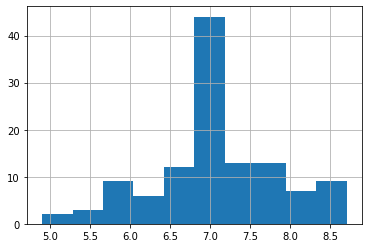

In [22]:
df['profit_per_flight'].hist()

### Визуализация

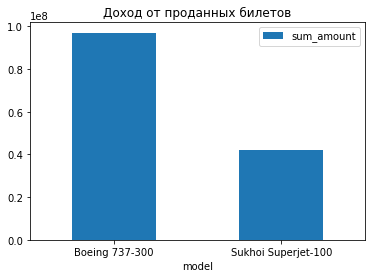

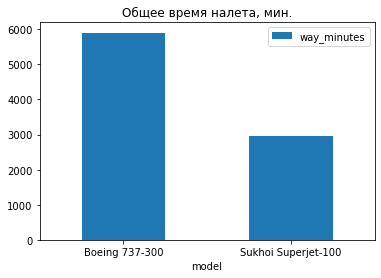

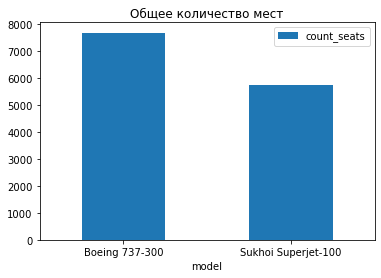

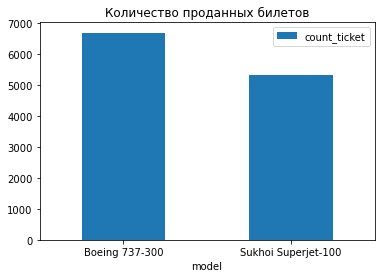

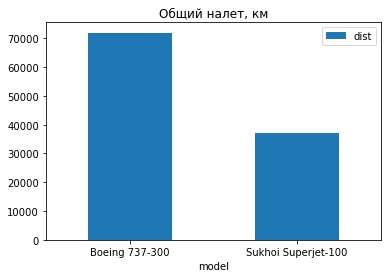

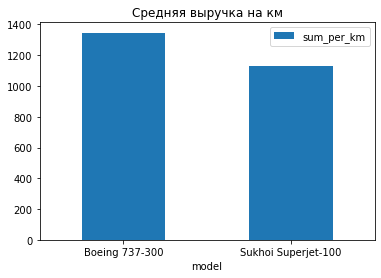

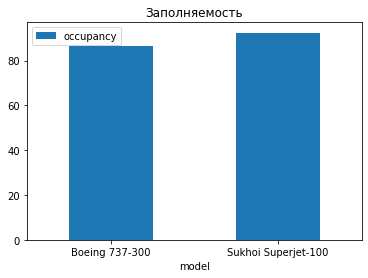

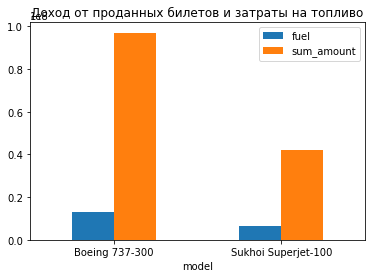

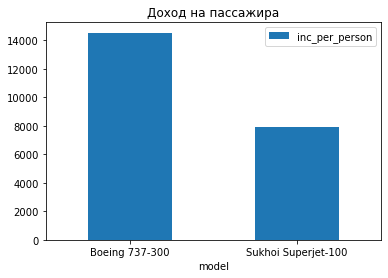

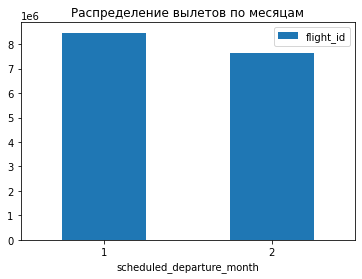

In [58]:
df.pivot_table(values = ['sum_amount'], 
               index = 'model', 
               aggfunc = 'sum').plot(kind = 'bar', rot=0)
plt.title ("Доход от проданных билетов")
df.pivot_table(values = ['way_minutes'], 
               index = 'model', 
               aggfunc = 'sum').plot(kind = 'bar', rot=0)
plt.title ("Общее время налета, мин.")

df.pivot_table(values = ['count_seats'], 
               index = 'model', 
               aggfunc = 'sum').plot(kind = 'bar', rot=0)
plt.title ("Общее количество мест")
df.pivot_table(values = ['count_ticket'], 
               index = 'model', 
               aggfunc = 'sum').plot(kind = 'bar', rot=0)
plt.title ("Количество проданных билетов")
df.pivot_table(values = ['dist'], 
               index = 'model', 
               aggfunc = 'sum').plot(kind = 'bar', rot=0)
plt.title ("Общий налет, км")
df.pivot_table(values = ['sum_per_km'], 
               index = 'model', 
               aggfunc = 'mean').plot(kind = 'bar', rot=0)
plt.title ("Средняя выручка на км")
df.pivot_table(values = ['occupancy'], 
               index = 'model', 
               aggfunc = 'mean').plot(kind = 'bar', rot=0)
plt.title ("Заполняемость")
df.pivot_table(values = ['sum_amount','fuel'], 
               index = 'model', 
               aggfunc = 'sum').plot(kind = 'bar', rot=0)
plt.title ("Доход от проданных билетов и затраты на топливо")
df.pivot_table(values = ['inc_per_person'], 
               index = 'model', 
               aggfunc = 'mean').plot(kind = 'bar', rot=0)
plt.title ("Доход на пассажира")
df.pivot_table(values = ['flight_id'], 
               index = 'scheduled_departure_month', 
               aggfunc = 'sum').plot(kind = 'bar', rot=0)
plt.title ("Распределение вылетов по месяцам")
plt.show()


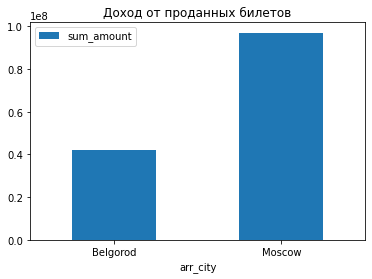

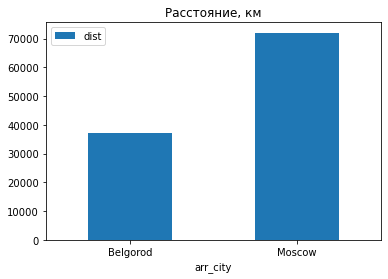

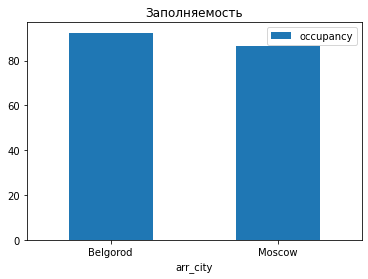

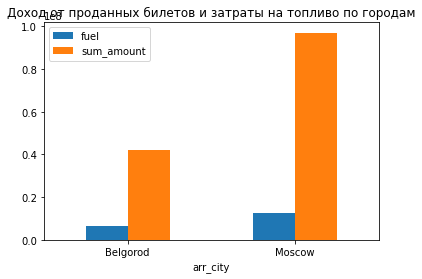

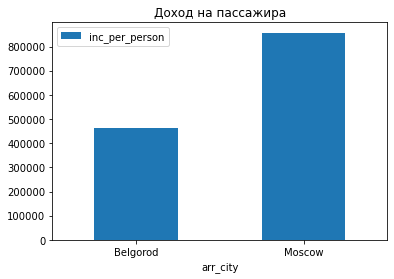

In [21]:
df.pivot_table(values = ['sum_amount'], 
               index = 'arr_city', 
               aggfunc = 'sum').plot(kind = 'bar', rot=0)
plt.title ("Доход от проданных билетов")

df.pivot_table(values = ['dist'], 
               index = 'arr_city', 
               aggfunc = 'sum').plot(kind = 'bar', rot=0)
plt.title ("Расстояние, км")

df.pivot_table(values = ['occupancy'], 
               index = 'arr_city', 
               aggfunc = 'mean').plot(kind = 'bar', rot=0)
plt.title ("Заполняемость")
df.pivot_table(values = ['sum_amount','fuel'], 
               index = 'arr_city', 
               aggfunc = 'sum').plot(kind = 'bar', rot=0)
plt.title ("Доход от проданных билетов и затраты на топливо по городам")
df.pivot_table(values = ['inc_per_person'], 
               index = 'arr_city', 
               aggfunc = 'sum').plot(kind = 'bar', rot=0)
plt.title ("Доход на пассажира")
plt.show()
